# Working with TFRecords
> Start to build up my dataset garden

- toc: true
- badges: true
- categories: [tfrecord, dataset garden]


In this notebook, I am going to discuss **Tensorflow Records** or **TFRecords**. Tensorflow recommends to store and read data in TFRecords format. It internally uses **Protocal Buffers** to serialize/deserialize the data and store them in bytes, as it takes less space to hold an ample amount of data and to transfer them as well.

In [2]:
#hide
%%writefile conditional_cell_extension.py
def run_if(line, cell=None):
    '''Execute current line/cell if line evaluates to True.'''
    if not eval(line):
        return
    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the run_if magic when the extension loads.'''
    shell.register_magic_function(run_if, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the run_if magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['run_if']

Overwriting conditional_cell_extension.py


In [3]:
#hide
%reload_ext conditional_cell_extension

In [4]:
#hide
!pip install -q imagehash > /dev/null

In [24]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, gc, cv2, random, re
import warnings, math, sys, json
import subprocess, pprint, pdb

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (f1_score, precision_score,
                             recall_score, confusion_matrix)
import glob, imagehash, copy
import concurrent.futures,time
from fastprogress.fastprogress import master_bar, progress_bar
from PIL import Image

warnings.simplefilter('ignore')
print(f"Using TensorFlow v{tf.__version__}")

Using TensorFlow v2.4.1


In [6]:
#hide
#@title Notebook type { run: "auto", display-mode:"form" }
SEED = 10120919
DEBUG = True #@param {type:"boolean"}

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

GOOGLE = 'google.colab' in str(get_ipython())
KAGGLE = not GOOGLE

seed_everything(SEED)

print("Running on {}!".format(
   "Google Colab" if GOOGLE else "Kaggle Kernel"
))

Running on Google Colab!


In [14]:
#hide
%%run_if {GOOGLE}
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [15]:
project_name = 'cassava-leaf-disease-classification'
root_path  = '/content/gdrive/MyDrive/' if GOOGLE else '/'
input_path = f'{root_path}kaggle/input/{project_name}/'
working_path = f'{input_path}working/' if GOOGLE else '/kaggle/working/'
os.makedirs(working_path, exist_ok=True)
os.chdir(working_path)
os.listdir(input_path)

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'cassava-leaf-disease-classification.zip',
 'test_images',
 'test_tfrecords',
 'train_images',
 'train_tfrecords',
 'dump.tfcache.data-00000-of-00001',
 'dump.tfcache.index',
 'working']

# Find Duplicates

My strategy will firstly pre-generate the four different hash values as the representation of each image. Therefore instead of comparing `480000` pixels between images, we use 256 integers for comparison.

In [16]:
funcs = [
    imagehash.average_hash,
    imagehash.phash,
    imagehash.dhash,
    imagehash.whash
]

In [17]:
def calculate_image_hash(fname):
    im = Image.open(fname)
    id = os.path.basename(fname)
    hash = np.array([f(im).hash for f in funcs]).reshape(256)
    return id,hash

In [18]:
filenames = glob.glob(f'{input_path}train_images/*.jpg')

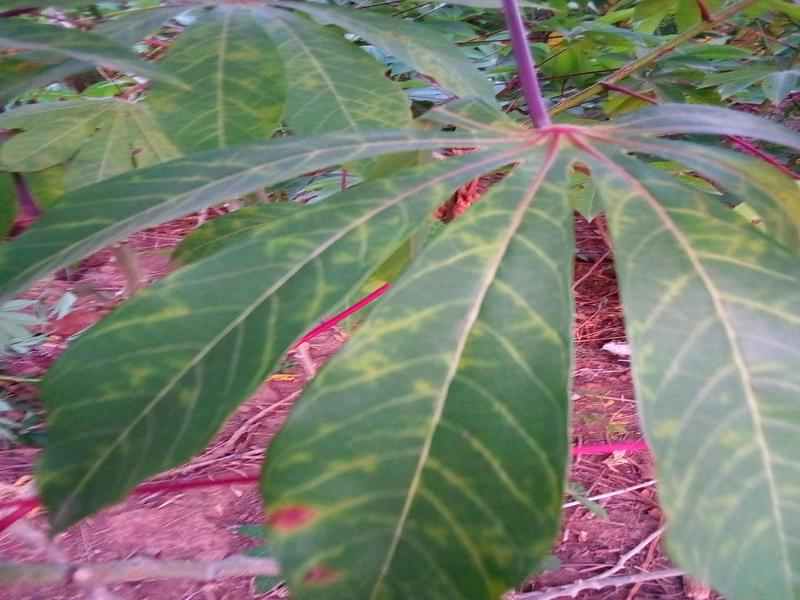

In [19]:
im = Image.open(filenames[0])
im

In [20]:
id,hash_array = calculate_image_hash(filenames[0])

In [21]:
#hide-collapse
def convert_array_to_string(hs):
    hash_string = "0x"
    res = 0
    for i,h in enumerate(hs, 1):
        res = (res << 1) | (1 if h else 0)
        if not (i % 64):
            hash_string += (str(format(res, 'x')))
            res = 0
    return hash_string

print(f"ID: {id}")
print(f"Hash: {convert_array_to_string(hash_array)}")

ID: 793578252.jpg
Hash: 0x30d83f1f1f1303e3add8660df90306f6d2b2fcbb3377c78770583f1f1f1303e3


In [22]:
#hide
fnames = filenames[:500].copy() if DEBUG else filenames

In [ ]:
tf.keras.utils.Progbar

In [27]:
%%run_if {DEBUG}
results = []
for fname in progress_bar(fnames):
    results.append(calculate_image_hash(fname))

## Speed up by using concurrency

> Tip: The above `calculate_image_hash()` can run in concurrency to speed up the process. The built-in `concurrent.futures` library comes to rescue.

In [ ]:
results1 = []
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    results1 = list(progress_bar(executor.map(calculate_image_hash, fnames), total=len(fnames)))

## Create similarity matrix to pinpoint duplicates

In [ ]:
img_ids,hashs = zip(*results1)

In [ ]:
hashs = np.asarray(hashs)
similarity_matrix = np.array([(hashs[i] == hashs).sum(axis=1)/256
    for i in range(hashs.shape[0])])

In [ ]:
identical_x,identical_y = np.where(similarity_matrix == 1)
identical_pos = np.where(identical_x != identical_y)
truncate = int(identical_pos[0].shape[0]/2)
ids_to_delete = list(identical_y[identical_pos])[:truncate]
print(f"Number of duplicates: {len(ids_to_delete)}")

Number of duplicates: 0


# Generate TF records

In [ ]:
#hide
#@title Hyperparams { run: "auto", display-mode:"form" }
NFILES =  15#@param {type:"integer"}
HEIGHT =  256#@param {type:"integer"}
WIDTH = 256#@param {type:"integer"}
IMG_SIZE = (HEIGHT, WIDTH, 3)
IMG_QUALITY = 100#@param {type:"integer"}

## Helper functions

In [ ]:
#hide-collpase
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string), 
        'target': tf.io.FixedLenFeature([], tf.int64), 
        'image_name': tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    target = example['target']
    name = example['image_name']
    return image, target, name

def load_dataset(filenames, HEIGHT, WIDTH, CHANNELS=3):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        image, label, name = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(image[0])
        plt.title(f"{label[0]}: {name[0].numpy().decode('utf-8')}", fontsize=12)
    plt.show()

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Create TF Records
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, target, image_name):
  feature = {
      'image': _bytes_feature(image),
      'target': _int64_feature(target),
      'image_name': _bytes_feature(image_name),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [ ]:
df = pd.read_csv(f'{input_path}train.csv')
print(f"Number of orginal dataset: {len(df)}")

Number of orginal dataset: 21397


In [ ]:
df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [ ]:
df = df[~df.image_id.isin(pd.Series(ids_to_delete))]
print(f'Number of training samples: {len(df)}')

Number of training samples: 21397


In [ ]:
df['path'] = df['image_id'].map(lambda x : f'{input_path}train_images/{x}')
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

image_id  label                                               path
0  3822634474.jpg      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...
1   643613398.jpg      2  /content/gdrive/MyDrive/kaggle/input/cassava-l...
2  1296498545.jpg      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...
3   295733469.jpg      4  /content/gdrive/MyDrive/kaggle/input/cassava-l...
4  1867630511.jpg      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...

In [ ]:
stratify = StratifiedKFold(n_splits=NFILES, shuffle=True, random_state=SEED)
df['file'] = -1

In [ ]:
for i,(train, valid) in enumerate(stratify.split(df, df['label'])):
    print(f"File #{i}: {len(valid)}")
    df['file'].loc[valid] = i

File #0: 1427
File #1: 1427
File #2: 1427
File #3: 1427
File #4: 1427
File #5: 1427
File #6: 1427
File #7: 1426
File #8: 1426
File #9: 1426
File #10: 1426
File #11: 1426
File #12: 1426
File #13: 1426
File #14: 1426


In [ ]:
df.head()

image_id  ...  file
0  3822634474.jpg  ...    10
1   643613398.jpg  ...     2
2  1296498545.jpg  ...     3
3   295733469.jpg  ...     3
4  1867630511.jpg  ...     0

[5 rows x 4 columns]

In [ ]:
df.to_csv('train.csv', index=False)

In [ ]:
mb = master_bar(range(NFILES))
for i in mb:
    samples = df[df['file'] == i]
    n_samples = len(samples)
    filename = 'Id_df%.2i-%i.tfrec' % (i, n_samples)

    with tf.io.TFRecordWriter(filename) as writer:
        for row in progress_bar(samples.itertuples(), total=len(samples), parent=mb):
            label = row.label
            img = cv2.imread(row.path)
            img = cv2.resize(img, (HEIGHT, WIDTH))
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, IMG_QUALITY))[1].tostring()
            example = serialize_example(img, label, str.encode(row.image_id))
            writer.write(example)

    mb.write(f'Finished writing to {filename}.')

# TFRecord basics

In [ ]:
#collapse-show
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers'
SHARDS = 16
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

### Read images and labels

In [ ]:
#collapse-show
def decode_image_and_label(filename):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
    #label = tf.strings.split(filename, sep='/')
    label = label.values[-2]
    label = tf.cast((CLASSES==label), tf.int8)
    return image, label

In [ ]:
filenames = tf.data.Dataset.list_files(GCS_PATTERN, seed=16)
for x in filenames.take(3): print(x)

tf.Tensor(b'gs://flowers-public/tulips/251811158_75fa3034ff.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/daisy/506348009_9ecff8b6ef.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/daisy/2019064575_7656b9340f_m.jpg', shape=(), dtype=string)


In [ ]:
#collapse-show
def show_images(ds):
    _,axs = plt.subplots(3,3,figsize=(16,16))
    for ((x, y), ax) in zip(ds.take(9), axs.flatten()):
        ax.imshow(x.numpy().astype(np.uint8))
        ax.set_title(np.argmax(y))
        ax.axis('off')

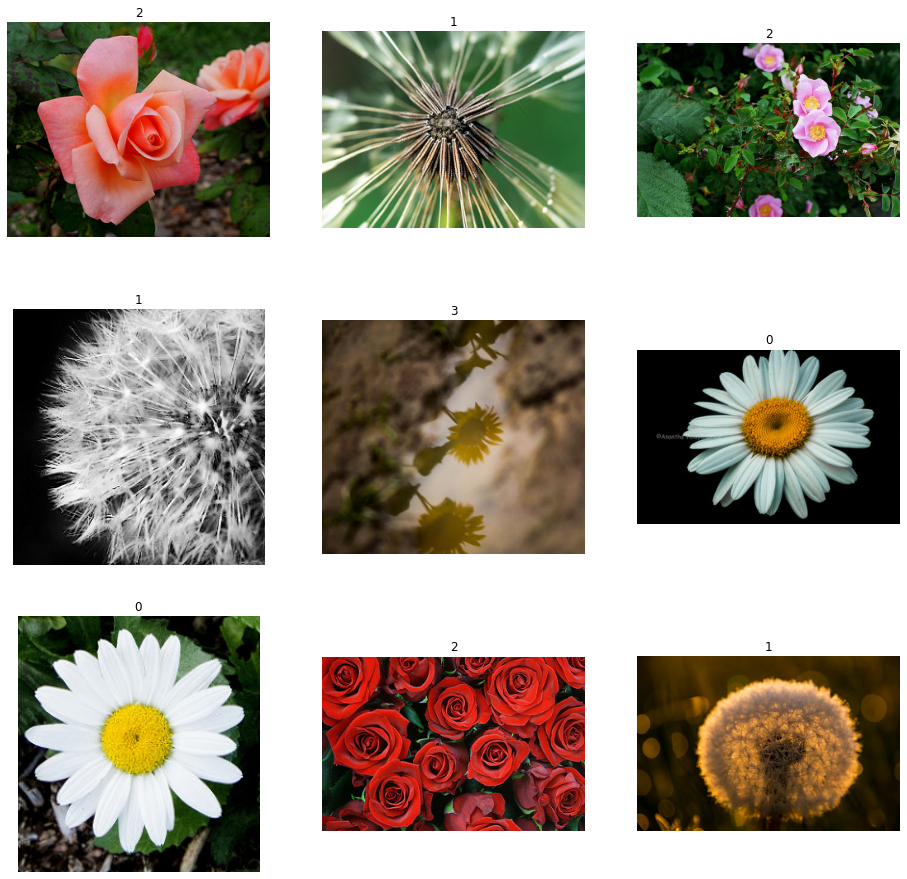

In [ ]:
ds0 = filenames.map(decode_image_and_label, num_parallel_calls=AUTOTUNE)
show_images(ds0)

### Resize and crop images to common size

No need to study the code in this cell. It's only image resizing.




In [ ]:
#collapse-show
def resize_and_crop_image(image, label):
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                   )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

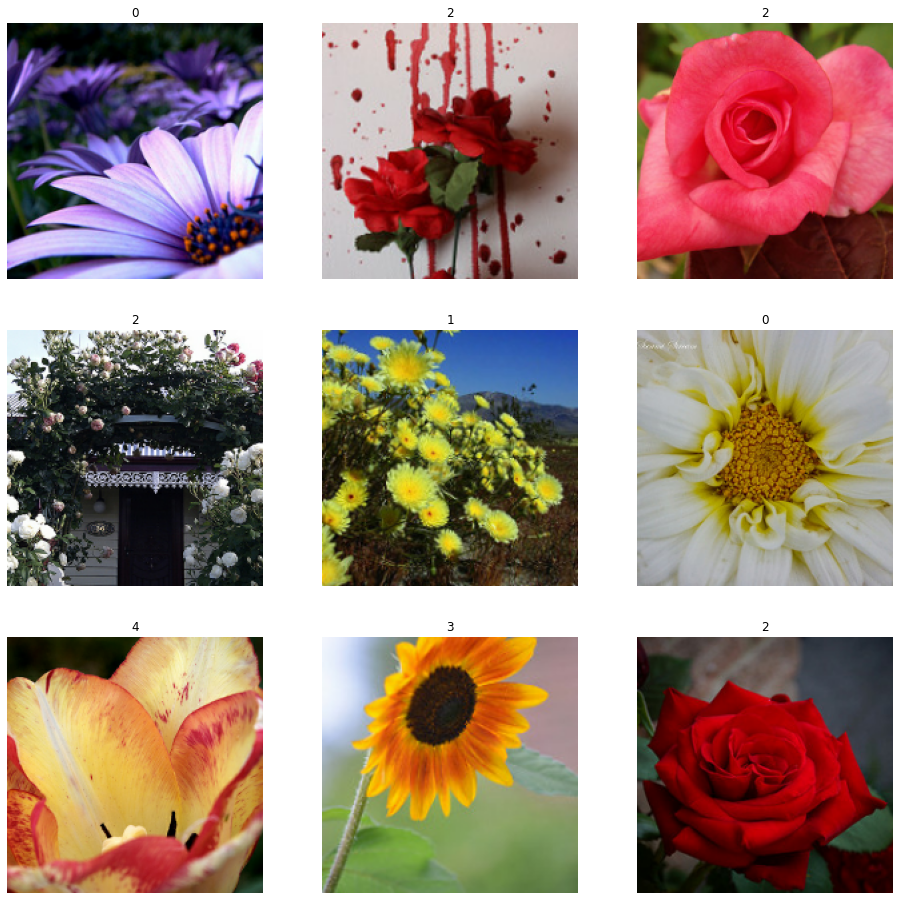

In [ ]:
ds1 = ds0.map(resize_and_crop_image, num_parallel_calls=AUTOTUNE) 
show_images(ds1)

### Speed test: too slow

Google Cloud Storage is capable of great throughput but has a per-file access penalty. Run the cell below and see that throughput is around 8 images per second. That is too slow. Training on thousands of individual files will not work. We have to use the *TFRecord* format to group files together.

In [ ]:
%%time
for image,label in ds1.batch(8).take(10):
    print("Image batch shape {} {}".format(
        image.numpy().shape,
        [np.argmax(lbl) for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3) [0, 1, 0, 0, 1, 3, 2, 1]
Image batch shape (8, 192, 192, 3) [3, 4, 4, 0, 3, 4, 3, 0]
Image batch shape (8, 192, 192, 3) [0, 3, 0, 4, 2, 4, 2, 4]
Image batch shape (8, 192, 192, 3) [3, 4, 4, 0, 2, 3, 2, 3]
Image batch shape (8, 192, 192, 3) [1, 3, 4, 3, 0, 3, 1, 3]
Image batch shape (8, 192, 192, 3) [4, 4, 3, 0, 0, 4, 4, 1]
Image batch shape (8, 192, 192, 3) [1, 3, 1, 3, 1, 2, 4, 2]
Image batch shape (8, 192, 192, 3) [1, 4, 2, 4, 2, 2, 1, 0]
Image batch shape (8, 192, 192, 3) [0, 3, 2, 2, 3, 4, 0, 1]
Image batch shape (8, 192, 192, 3) [1, 2, 0, 1, 0, 3, 4, 1]
CPU times: user 60 ms, sys: 54.4 ms, total: 114 ms
Wall time: 5.62 s


### Recompress the images

The bandwidth savings outweight the decoding CPU cost

In [ ]:
#collapse-show
def recompress_image(image, label):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label, height, width

In [ ]:
IMAGE_SIZE = len(tf.io.gfile.glob(GCS_PATTERN))
SHARD_SIZE = math.ceil(1.0 * IMAGE_SIZE / SHARDS)

In [ ]:
ds2 = ds1.map(recompress_image, num_parallel_calls=AUTOTUNE)
ds2 = ds2.batch(SHARD_SIZE)

### Why TFRecords?

TPUs have eight cores which act as eight independent workers. We can get data to each core more efficiently by splitting the dataset into multiple files or *shards*. This way, each core can grab an independent part of the data as it needs.
The most convenient kind of file to use for sharding in TensorFlow is a TFRecord. A TFRecord is a binary file that contains sequences of byte-strings. Data needs to be serialized (encoded as a byte-string) before being written into a TFRecord.
The most convenient way of serializing data in TensorFlow is to wrap the data with `tf.Example`. This is a record format based on Google's protobufs but designed for TensorFlow. It's more or less like a dict with some type annotations

In [ ]:
x = tf.constant([[1,2], [3, 4]], dtype=tf.uint8)
print(x)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=uint8)


In [ ]:
x_in_bytes = tf.io.serialize_tensor(x)
print(x_in_bytes)

tf.Tensor(b'\x08\x04\x12\x08\x12\x02\x08\x02\x12\x02\x08\x02"\x04\x01\x02\x03\x04', shape=(), dtype=string)


In [ ]:
print(tf.io.parse_tensor(x_in_bytes, out_type=tf.uint8))

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=uint8)


A TFRecord is a sequence of bytes, so we have to turn our data into byte-strings before it can go into a TFRecord. We can use tf.io.serialize_tensor to turn a tensor into a byte-string and tf.io.parse_tensor to turn it back. It's important to keep track of your tensor's datatype (in this case tf.uint8) since you have to specify it when parsing the string back to a tensor again

### Write dataset to TFRecord files

> Note: Will uncomment the cells in this section when I find a `gs://` domain to write to.




In [ ]:
#hide
#def _bytestring_feature(list_of_bytestrings):
#    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))
#
#def _int_feature(list_of_ints): # int64
#    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))
#
#def _float_feature(list_of_floats): # float32
#    return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
#
#def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):
#    id = np.argmax(np.array(CLASSES)==label)
#    one_hot = np.eye(len(CLASSES))[id]
#    feature = {
#      "image": _bytestring_feature([img_bytes]), # one image in the list
#      "id":    _int_feature([id]),               # one class in the list
#      "label": _bytestring_feature([label]),     # fixed length (1) list of strings, the text label
#      "size" : _int_feature([height, width]),    # fixed length (2) list of ints
#      "one_hot": _float_feature(one_hot.tolist())# variable length  list of floats, n=len(CLASSES)
#    }
#    return tf.train.Example(features=tf.train.Features(feature=feature))
#
#print("Writing TFRecords")
#for shard_id, (image, label, height, width) in ds2.enumerate():
#    shard_size = image.numpy().shape[0]
#    filename = GCS_OUTPUT + "{:02d}-{}tfrec".format(shard_id, shard_size)
#
#    with tf.io.TFRecordWriter(filename) as outfile:
#        for i in range(shard_size):
#            example = to_tfrecord(out_file,
#                                  image.numpy()[i],
#                                  label.numpy()[i],
#                                  height.numpy()[i],
#                                  width.numpy()[i])
#            out_file.write(example.SerializeToString())
#        print("Wrote file {} containing {} records".format(filename, shard_size))

### Read from TFRecord Dataset

In [ ]:
#collapse-show
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class

In [ ]:
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*tfrec")
ds3 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
ds3 = (ds3.with_options(option_no_order)
         .map(read_tfrecord, num_parallel_calls=AUTOTUNE)
         .shuffle(30))

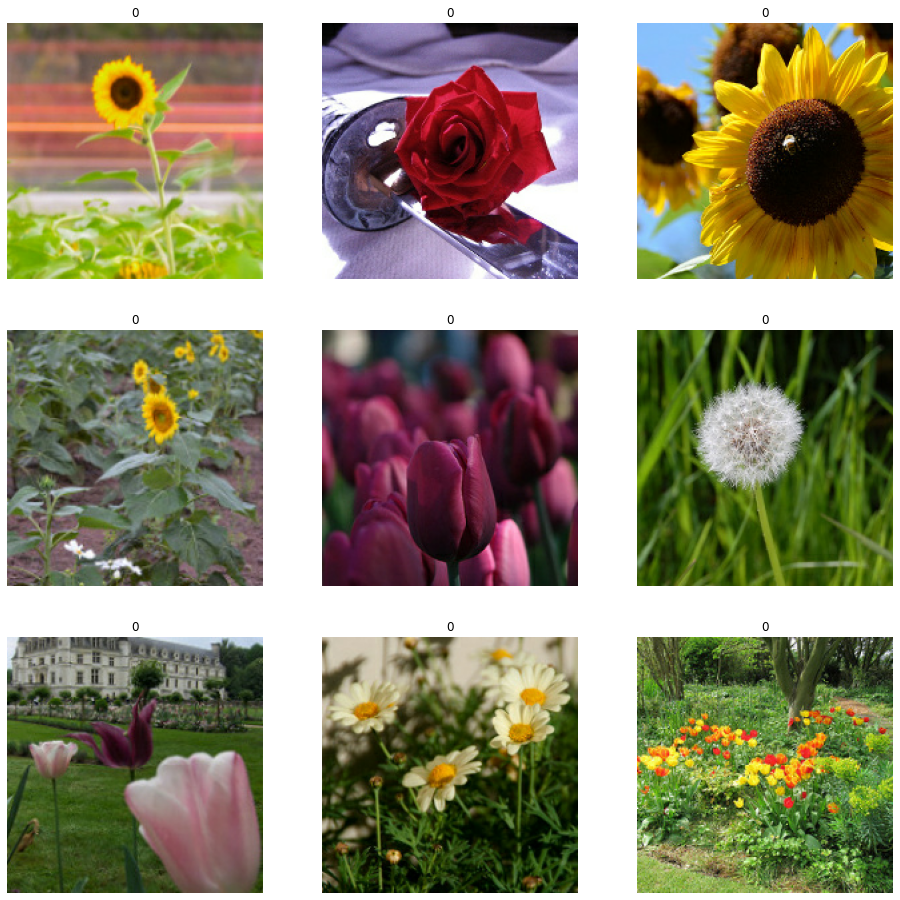

In [ ]:
ds3_to_show = ds3.map(lambda image, id, label, height, width, one_hot: (image, label))
show_images(ds3_to_show)

### Speed test: fast

Loading form TFRecords is almost 10x time faster than loading from JPEGs.

In [ ]:
%%time
for image, class_num, label, height, width, one_hot_class in ds3.batch(8).take(10):
    print("Image batch shape {} {}".format(
        image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3) ['roses', 'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'daisy', 'dandelion', 'tulips']
Image batch shape (8, 192, 192, 3) ['roses', 'dandelion', 'sunflowers', 'tulips', 'sunflowers', 'dandelion', 'roses', 'dandelion']
Image batch shape (8, 192, 192, 3) ['daisy', 'daisy', 'sunflowers', 'roses', 'roses', 'daisy', 'sunflowers', 'tulips']
Image batch shape (8, 192, 192, 3) ['roses', 'roses', 'roses', 'tulips', 'sunflowers', 'tulips', 'tulips', 'tulips']
Image batch shape (8, 192, 192, 3) ['sunflowers', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'sunflowers', 'roses']
Image batch shape (8, 192, 192, 3) ['roses', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'dandelion']
Image batch shape (8, 192, 192, 3) ['dandelion', 'sunflowers', 'daisy', 'sunflowers', 'sunflowers', 'sunflowers', 'dandelion', 'daisy']
Image batch shape (8, 192, 192, 3) ['roses', 'daisy', 'dandelion', 'sunflowers', 'sunflowers', 'd